# Whatsapp Chat Analyzer

This code generates some interesting data visualization for a whatsapp group chat history.

This takes the group chat history text as an input.

To export group chat history in whatsapp, go to group chat > Settings > More > Export Chat > Without Media

You need the following libraries in your python environment
nltk (Also download nltk data stopwords and vader_lexicon)
matplotlib


Reference: https://towardsdatascience.com/build-your-own-whatsapp-chat-analyzer-9590acca9014

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
%matplotlib inline

C:\project\Anaconda\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#### Defining some static variables for regular expression

In [2]:
# fig, axs = plt.subplots(60,1)
# #size in inches for the plot
# plt_size = [12,480]


mediaPattern = r"(\<Media omitted\>)" # Because it serves no purpose
regexMedia = re.compile(mediaPattern, flags=re.M)

dateAndTimepattern = r"(\d+\/\d+\/\d+)(,)(\s)(\d+:\d+)(\s)(\w+)(\s)(-)(\s\w+)*(:)"
regexDate = re.compile(dateAndTimepattern, flags=re.M)

#### Define path to the input text file & read the file

In [3]:
def readFile(filename):
    chat = open(filename, 'r', encoding='utf-8')
    chatText = chat.read()
    chat.close()

    lines = []
    for line in chatText.splitlines():
        if line.strip() is not "": # If it's empty, we don't need it
            lines.append(line.strip())
    return lines

lines = readFile("<path to text file>")

print('Number of lines in the file: ' + str(len(lines)))

Number of lines in the file: 4305


Parse all lines and convert into a tuple of date, time, author and message.

Each line which starts with a date is the start of a new message, followed by time, author and a single / multi line message.

Join multi line messages into a single string.



In [4]:
def get_data(lines):
    parsed_data = []
    message_buffer = []
    date, time, author = None, None, None
    for line in lines:

        if starts_with_date(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            # print(line)
            if len(message_buffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsed_data.append([date, time, author, ' '.join(message_buffer)]) # Save the tokens from the previous message in parsedData
            message_buffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = get_data_point(line) # Identify and extract tokens from the line
            message_buffer.append(message) # Append message to buffer
        else:
                message_buffer.append(line)

    return parsed_data


def starts_with_date(s):
    pattern = '[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,2}, [0-9]{1,2}:[0-9]{1,2} [AP]M -'
    result = re.match(pattern, s)
    if result:
        return True
    return False


def starts_with_author(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def get_data_point(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?

    split_line = line.split(' - ')  # split_line = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']

    date_time = split_line[0]  # date_time = '18/06/17, 22:47'

    date, time = date_time.split(', ')  # date = '18/06/17'; time = '22:47'

    message = ' '.join(split_line[1:])  # message = 'Loki: Why do you have 2 numbers, Banner?'

    if starts_with_author(message):  # True
        split_message = message.split(': ')  # split_message = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = split_message[0]  
        message = ' '.join(split_message[1:])  # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

data = get_data(lines)
print('Number of messages ' + str(len(data)))


Number of messages 3581


Parse all lines and convert into a dataframe with 4 columns - 'Date', 'Time', 'Author', 'Message'

In [5]:
def get_data_frame(data):
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message'])
    df.head()
    df.drop(df.index[:1], inplace=True)
    df.to_csv(index=False, path_or_buf='C:/temp/out.csv' )
    return df

df = get_data_frame(data)
df.head()


,Date,Time,Author,Message
1,6/11/18,5:51 PM,Shabbir Husain JC,Does anyon3 have Ria account for money transfe...
2,6/11/18,5:51 PM,Mustafa Motiwala,Yes
3,6/11/18,8:23 PM,Shabbir Husain JC,Thanks..Jaora reached out first and provided r...
4,6/11/18,8:27 PM,Murtuza Jaorawala,Maybe difference of few seconds😄
5,6/11/18,8:27 PM,Murtuza Jaorawala,Still didn't matter 😜


Print last few messages

In [6]:
df.tail()

,Date,Time,Author,Message
3576,12/11/19,12:31 PM,Qusai jpmc,"Haha thanks and good to you, anyways I am not ..."
3577,12/11/19,12:52 PM,Shabbir Husain JC,"When we have tried using it, the agent at the ..."
3578,12/11/19,12:55 PM,Qusai jpmc,Yes 👍
3579,12/12/19,1:14 PM,Asad,<Media omitted>
3580,12/13/19,6:38 AM,Murtuza Jaorawala,<Media omitted>


Describe dataframe

In [7]:
df.describe()

,Date,Time,Author,Message
count,3580,3580,3561,3580
unique,308,976,9,2968
top,7/16/18,11:11 AM,Mustafa Motiwala,<Media omitted>
freq,97,23,902,311


Export data frame to CSV

In [8]:
df.to_csv(path_or_buf='C:/temp/df.csv')

#### Plot horizontal bar graph of Author vs Number of messages

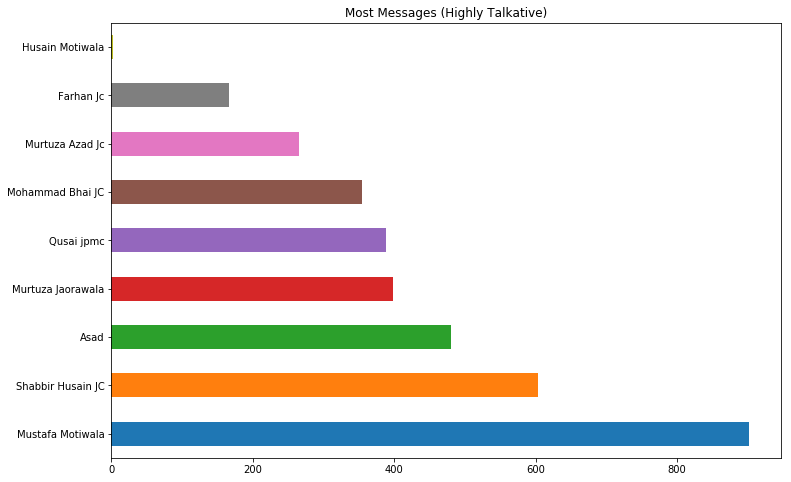

In [9]:
def print_messages_by_author(df):
    #Total messages by Author
    author_value_counts = df['Author'].value_counts() 
    # Number of messages per author
    #pprint(author_value_counts)
    top_10_author_value_counts = author_value_counts.head(18)
    # Number of messages per author for the top 10 most active authors
    plt = top_10_author_value_counts.plot.barh( figsize=[12,8],
                                               title='Most Messages (Highly Talkative)') # Plot a bar chart using pandas built-in plotting apis
    
    
print_messages_by_author(df)

#### Plot horizontal bar graph of Author vs Number of media messages

Total number of media messages: 311


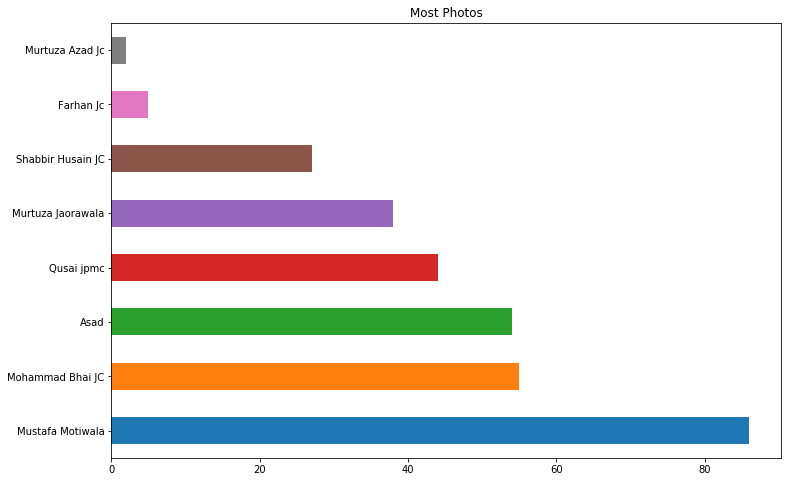

In [10]:
     
def print_media_messages_by_author(df):
    #Media messages by Author
    # Plot a bar chart using pandas built-in plotting apis
    media_messages_df = df[df['Message'] == '<Media omitted>']
    media_messages_count = media_messages_df['Author'].value_counts() 
    #pprint(media_messages_count)
    media_messages_count.plot.barh(figsize=[12,8], title='Most Photos') 
    
    return media_messages_df

media_messages_df = print_media_messages_by_author(df)
print('Total number of media messages: ' + str(len(media_messages_df.index)))

Remove media messages for further analysis of text messages

In [11]:

def remove_media_messages(df, media_messages_df):
    #Remove media messages
    messages_df = df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
    messages_df.head()
    #print(messages_df)
    return messages_df

messages_df = remove_media_messages(df, media_messages_df)
print('Total number of non media messages: ' + str(len(messages_df.index)))

Total number of non media messages: 3269


Add new columns word count and letter counts

In [12]:
def add_word_count(messages_df):
    messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
    messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
    print('Total Number of words: ' + str(messages_df['Word_Count'].sum()))
    print('Total Number of letters: ' + str(messages_df['Letter_Count'].sum()))
    return messages_df


messages_df = add_word_count(messages_df)
messages_df.head()


Total Number of words: 39374
Total Number of letters: 216062


,Date,Time,Author,Message,Letter_Count,Word_Count
1,6/11/18,5:51 PM,Shabbir Husain JC,Does anyon3 have Ria account for money transfe...,57,10
2,6/11/18,5:51 PM,Mustafa Motiwala,Yes,3,1
3,6/11/18,8:23 PM,Shabbir Husain JC,Thanks..Jaora reached out first and provided r...,54,7
4,6/11/18,8:27 PM,Murtuza Jaorawala,Maybe difference of few seconds😄,32,5
5,6/11/18,8:27 PM,Murtuza Jaorawala,Still didn't matter 😜,21,4


In [13]:
messages_df.describe()

,Letter_Count,Word_Count
count,3269.000000,3269.000000
mean,66.094218,12.044662
std,90.901676,17.136730
min,1.000000,1.000000
25%,17.000000,3.000000
50%,40.000000,7.000000
75%,83.000000,15.000000
max,1296.000000,290.000000


#### Plot horizontal bar graph of Author vs word count 

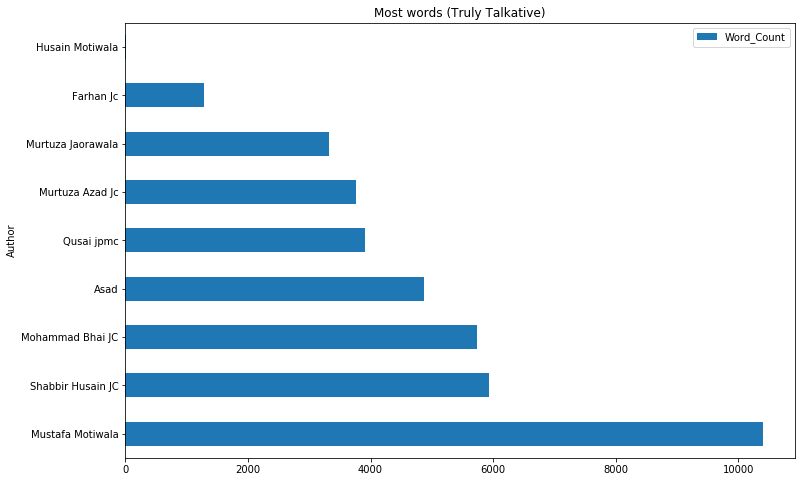

In [14]:
def print_word_count_by_author(messages_df):
    #Word count by Author 
    total_word_count_grouped_by_author = messages_df[['Author',
                                                      'Word_Count']].groupby('Author').sum()
    sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count',
                                                                                               ascending=False)
    top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(20)
    top_10_sorted_total_word_count_grouped_by_author.plot.barh(figsize=[12,8], 
                                                            title='Most words (Truly Talkative)')

    
print_word_count_by_author(messages_df)


#### Plot horizontal bar graph of Author vs Letter count

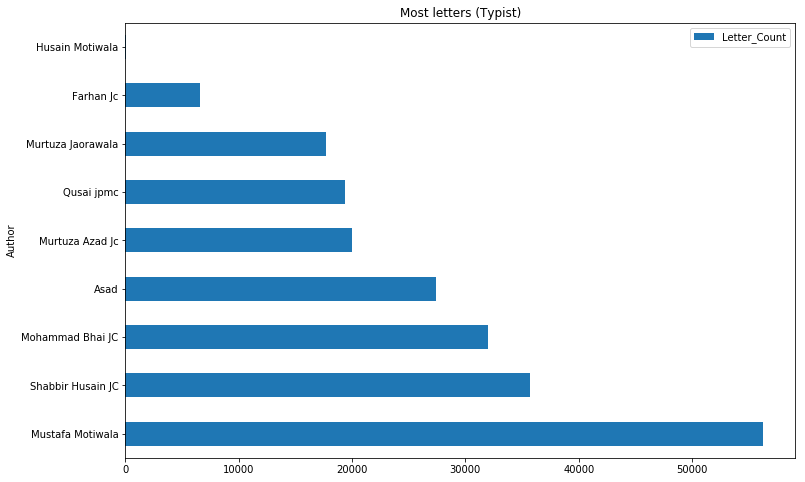

In [15]:
def print_letter_count_by_author(messages_df):
    total_letter_count_grouped_by_author = messages_df[['Author', 'Letter_Count']].groupby('Author').sum()
    sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
    top_10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_grouped_by_author.head(16)
    top_10_sorted_total_letter_count_grouped_by_author.plot.barh( figsize=[12,8],title='Most letters (Typist)')

print_letter_count_by_author(messages_df)

#### Plot most active dates for the group

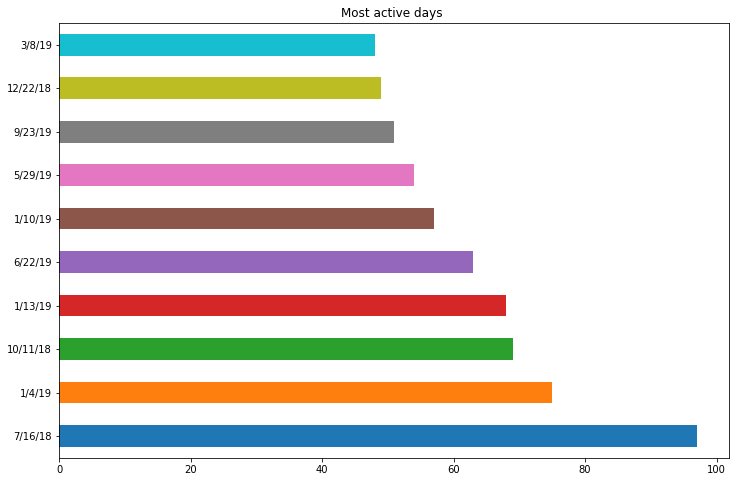

In [16]:
def print_most_active_dates(messages_df):
    #Date with most messages
    date_counts = messages_df['Date'].value_counts()
    #print(date_counts)
    date_counts.sort_values(ascending=False).head(10).plot.barh(figsize=[12,8],title='Most active days ') 
   
               
print_most_active_dates(messages_df)

#### Plot most active dates for each person in the group 

In terms of sending messages

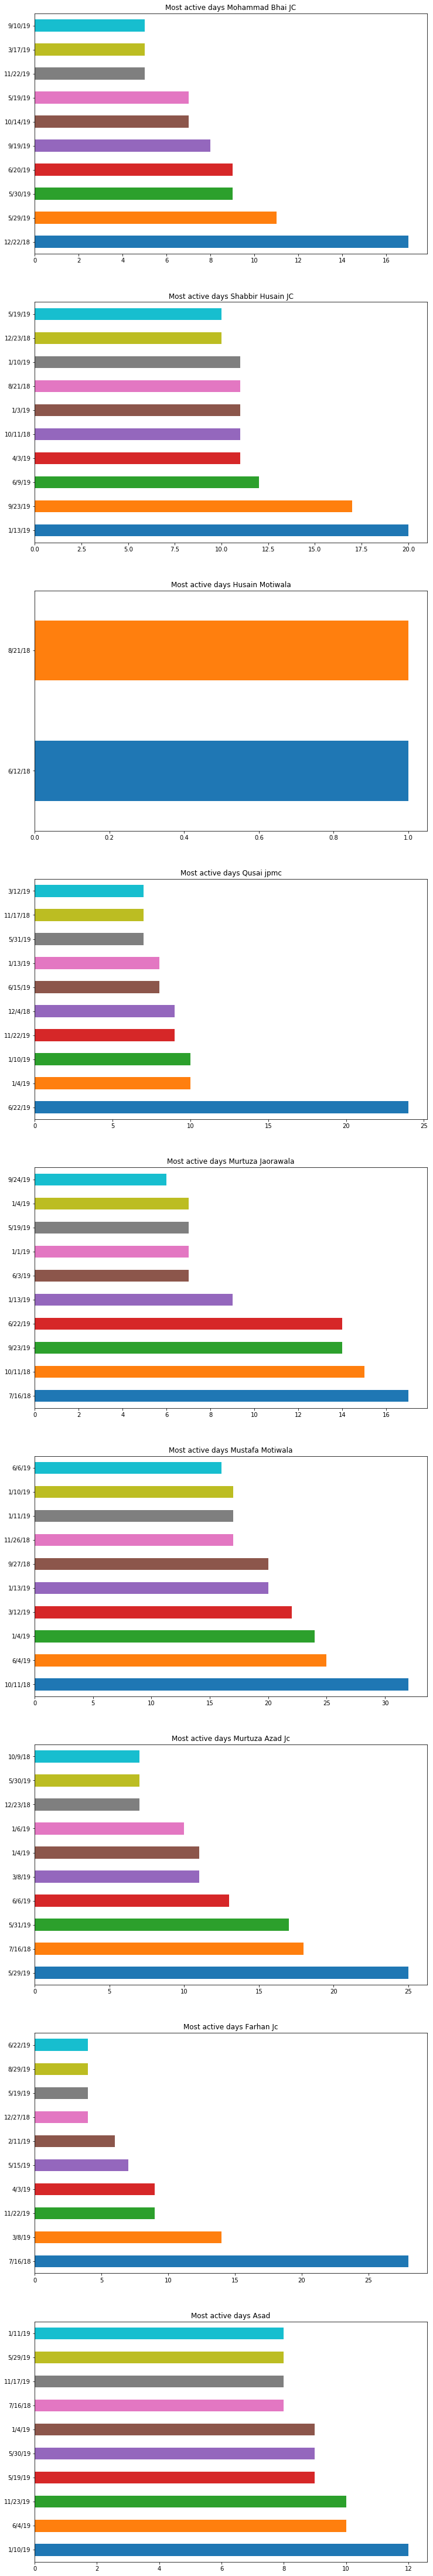

In [25]:
number_of_authors = len(set(messages_df['Author']))
fig, axs = plt.subplots(number_of_authors-1,1)
plot_size=[12, number_of_authors*8]

def print_most_active_dates_by_author(messages_df):
    i = 0
    for author in set(messages_df['Author']):
        messages_author = messages_df.loc[messages_df['Author'] == author]
        
        if len(messages_author > 0):
            date_counts = messages_author['Date'].value_counts()
            date_counts.sort_values(ascending=False).head(10).plot.barh(ax=axs[i],
                                    figsize=plot_size,title='Most active days ' + author) 
            i+=1
   

print_most_active_dates_by_author(messages_df)

#### Plot horizontal bar graph for number of messages vs hour of the day

Create a new column hour from date

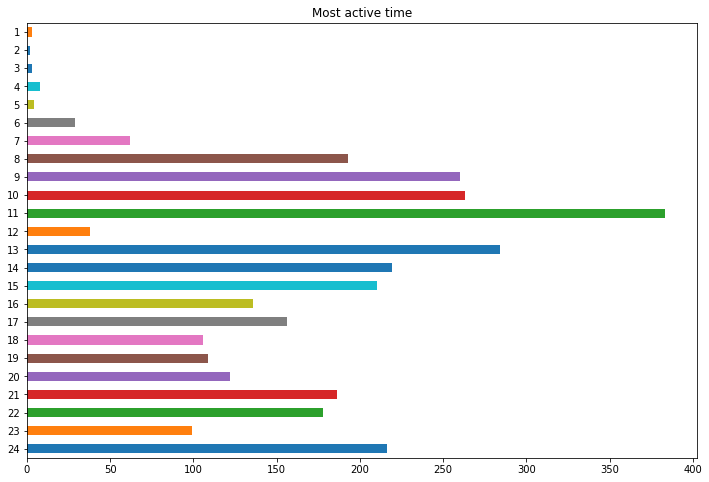

In [18]:
def print_most_active_hour(messages_df):
    #Time with most messages
    messages_df['Hour'] = messages_df['Time'].apply(lambda x : int(x.split(':')[0]) if 'AM' in x else int(x.split(':')[0]) + 12 )
    messages_df['Hour'].value_counts().sort_index(ascending=False).plot.barh(
         figsize=[12,8], title='Most active time')
    
print_most_active_hour(messages_df)


#### Plot number of messages vs hour for each person in the group

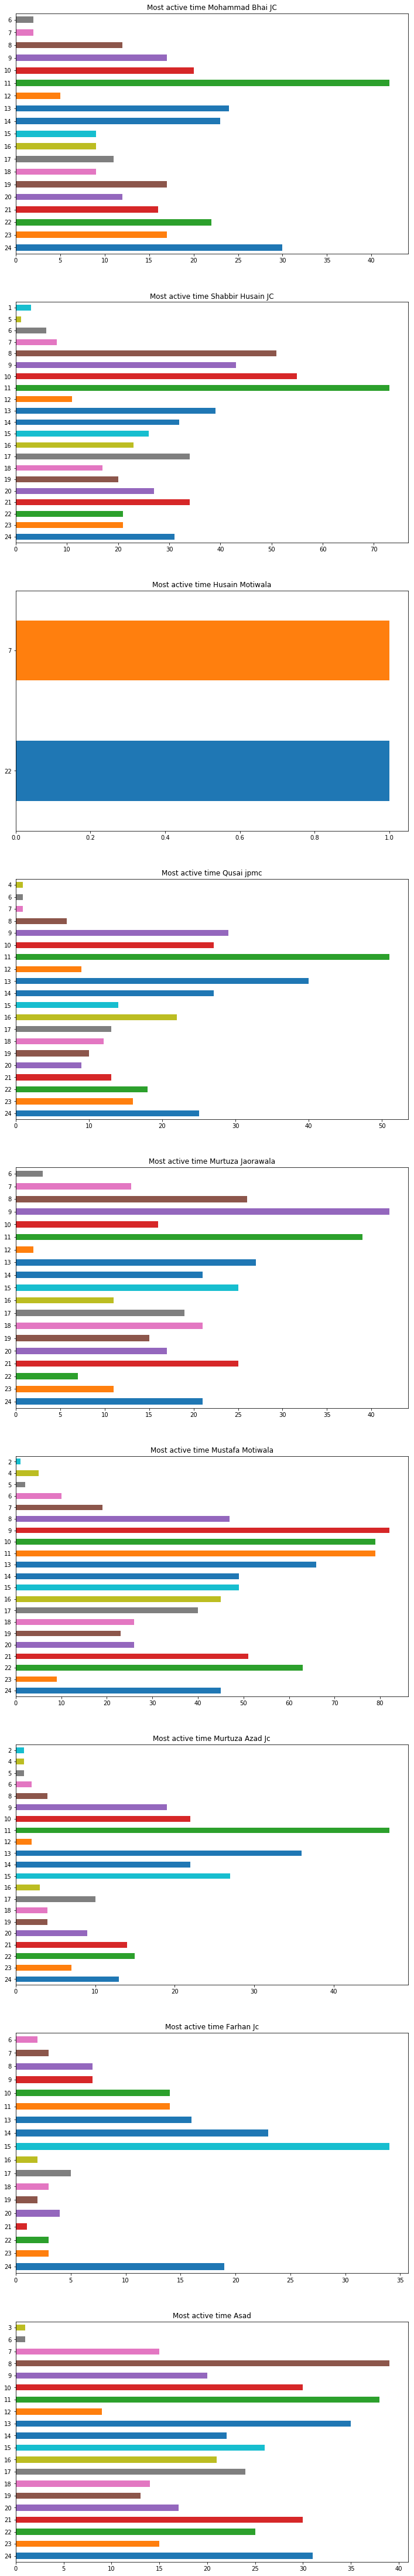

In [26]:
number_of_authors = len(set(messages_df['Author']))
fig, axs = plt.subplots(number_of_authors - 1,1)
plot_size=[12, number_of_authors*8]

def print_most_active_hour_by_author(messages_df):
    i = 0
    for author in set(messages_df['Author']):
        messages_author = messages_df.loc[messages_df['Author'] == author]
        if len(messages_author > 0):
         #Time with most messages
            messages_author['Hour'].value_counts().sort_index(ascending=False).plot.barh(
                ax=axs[i],  figsize=plot_size, title='Most active time ' + author)
            i+=1
            
        
print_most_active_hour_by_author(messages_df)


Tokenize all messages.


In [20]:
tokenizer = RegexpTokenizer(r'\w+')

messages_df['Tokens'] = messages_df['Message'].apply(tokenizer.tokenize)
messages_df.head()



,Date,Time,Author,Message,Letter_Count,Word_Count,Hour,Tokens
1,6/11/18,5:51 PM,Shabbir Husain JC,Does anyon3 have Ria account for money transfe...,57,10,17,"[Does, anyon3, have, Ria, account, for, money,..."
2,6/11/18,5:51 PM,Mustafa Motiwala,Yes,3,1,17,[Yes]
3,6/11/18,8:23 PM,Shabbir Husain JC,Thanks..Jaora reached out first and provided r...,54,7,20,"[Thanks, Jaora, reached, out, first, and, prov..."
4,6/11/18,8:27 PM,Murtuza Jaorawala,Maybe difference of few seconds😄,32,5,20,"[Maybe, difference, of, few, seconds]"
5,6/11/18,8:27 PM,Murtuza Jaorawala,Still didn't matter 😜,21,4,20,"[Still, didn, t, matter]"


Find all unique words.

Remove all stop words.

Plot frequency distribution of all words.

Total number of unique words 6558


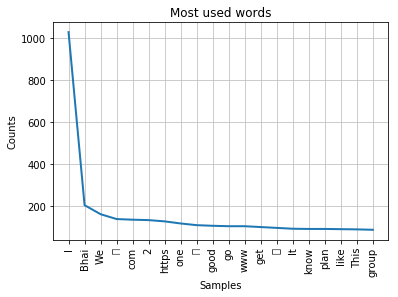

In [21]:
unique_words = {word for tokens in messages_df.Tokens for word in tokens}
all_words = [word for tokens in messages_df.Tokens for word in tokens]
print("Total number of unique words "+ str(len(unique_words)))
# pprint(all_words)

sr = stopwords.words('english')
clean_tokens = [t for t in all_words if t not in stopwords.words('english')]
word_frequency_dist = nltk.FreqDist(clean_tokens)
word_frequency_dist.plot(20, cumulative=False, title='Most used words')

##### Find most repeating trigrams

Top 50 3 letter sequences: 
[(('www', 'groupon', 'com'), 31), (('This', 'message', 'deleted'), 30), (('groupon', 'com', 'deals'), 29), (('https', 'www', 'groupon'), 20), (('http', 'www', 'groupon'), 11), (('utm_campaign', 'UserReferral_mih', 'utm_source'), 11), (('UserReferral_mih', 'utm_source', 'undefined'), 11), (('utm_source', 'utm_campaign', 'UserReferral_ma'), 11), (('com', 'deals', 'gl'), 9), (('security', 'code', 'changed'), 9), (('code', 'changed', 'Tap'), 9), (('changed', 'Tap', 'info'), 9), (('Please', 'let', 'know'), 6), (('क', 'कर', 'म'), 6), (('MM', 'QRV', 'MJ'), 6), (('If', 'anyone', 'interested'), 6), (('https', 'yelp', 'qTKq'), 6), (('https', 'www', 'amazon'), 5), (('Shabbir', 'Husain', 'JC'), 5), (('message', 'deleted', 'This'), 5), (('deleted', 'This', 'message'), 5), (('let', 'us', 'know'), 5), (('Indoor', 'Extreme', 'Sports'), 5), (('ट', 'र', 'न'), 5), (('ज', 'ज', 'र'), 5), (('न', 'ह', 'म'), 5), (('June', '22', '23'), 5), (('ख', 'ल', 'त'), 5), (('ल', 'त', 'ह'), 5),

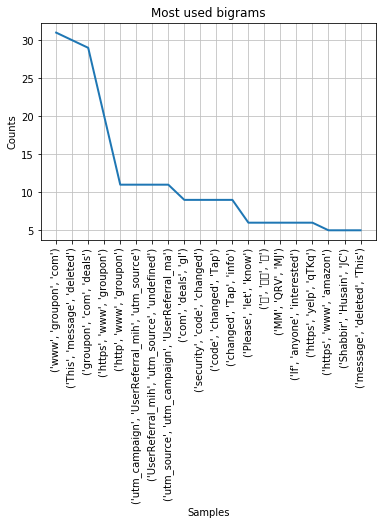

In [22]:
trigram_frequency_dist = nltk.FreqDist(nltk.everygrams(clean_tokens, min_len=3, max_len=3))
    

print('Top 50 3 letter sequences: ')
print(trigram_frequency_dist.most_common(50))
trigram_frequency_dist.plot(20,cumulative=False, title='Most used bigrams')

##### Get sentiment of each message

Create a new column Sentiment

In [23]:
sentiment_analyzer = SentimentIntensityAnalyzer()
messages_df['Sentiment'] = messages_df['Message'].apply(sentiment_analyzer.polarity_scores)
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count,Hour,Tokens,Sentiment
1,6/11/18,5:51 PM,Shabbir Husain JC,Does anyon3 have Ria account for money transfe...,57,10,17,"[Does, anyon3, have, Ria, account, for, money,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,6/11/18,5:51 PM,Mustafa Motiwala,Yes,3,1,17,[Yes],"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."
3,6/11/18,8:23 PM,Shabbir Husain JC,Thanks..Jaora reached out first and provided r...,54,7,20,"[Thanks, Jaora, reached, out, first, and, prov...","{'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'comp..."
4,6/11/18,8:27 PM,Murtuza Jaorawala,Maybe difference of few seconds😄,32,5,20,"[Maybe, difference, of, few, seconds]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,6/11/18,8:27 PM,Murtuza Jaorawala,Still didn't matter 😜,21,4,20,"[Still, didn, t, matter]","{'neg': 0.349, 'neu': 0.651, 'pos': 0.0, 'comp..."


#### Plot a pie chart for overall sentiment of the group chat

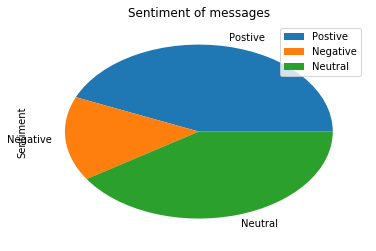

In [24]:
def print_sentiments(sentiment_scores):
    
    positives = np.array([x['pos'] for x in sentiment_scores])
    positives = positives[positives != 0]
    positive_score = (len(positives) / len (sentiment_scores))*100
    #print('Positive sentiment ' + str(positive_score))
    
    negatives = np.array([x['neg'] for x in sentiment_scores])
    negatives = negatives[negatives != 0]
    negative_score = (len(negatives) / len (sentiment_scores))*100
    #print('Negative sentiment ' + str(negative_score))
    label = ['Postive','Negative','Neutral']
    sentiment = pd.DataFrame({'Sentiment':[positive_score,
                                           negative_score, 100-positive_score-negative_score]},
                            index = label)
    
    sentiment.plot.pie(y='Sentiment', title='Sentiment of messages')
    
print_sentiments(messages_df['Sentiment'].values)